In [1]:
from torch import optim
import torch.utils.data as data
from setting_model import *
import numpy as np
import os

CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
# Model instantiation
# forward_model = model
#forward_model = FC_Net_2D().to(device)

iteration = 0
interval = 100
batch_size = 100
lr = 0.0005     # 3e-4
epoch = 5000
iter_num = []
losses = {'err_train': [], 'err_test': [], 'loss_train': [], 'loss_test': []}

In [3]:
# Gets the relevant file path
data_root = os.getcwd()

train_trajectory_path = os.path.join(data_root, "Train_Data", "trajectory_train_2105.csv")
assert os.path.exists(train_trajectory_path), "{} path does not exist.".format(train_trajectory_path)

test_trajectory_path = os.path.join(data_root, "Train_Data", "trajectory_test_2105.csv")
assert os.path.exists(test_trajectory_path), "{} path does not exist.".format(test_trajectory_path)

# Save the updated weights file
#save_dir = os.path.join(data_root, "weight_optim")
#assert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)

In [4]:
# Loader Data
train_numpy = np.loadtxt(train_trajectory_path, delimiter=",")
train_input = torch.FloatTensor(train_numpy[:, 0:100]).to(device)
train_label = torch.FloatTensor(train_numpy[:, 100:2100]).to(device)
train_input = train_input*1e6
train_label = train_label*1e6
train_dataset = data.TensorDataset(train_input, train_label)
data_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)    # 提取训练数据集并加载

test_numpy = np.loadtxt(test_trajectory_path, delimiter=",")
test_input = torch.FloatTensor(test_numpy[:, 0:100]).to(device)
test_label = torch.FloatTensor(test_numpy[:, 100:2100]).to(device)                               # 提取测试数据集
test_input = test_input*1e6  
test_label = test_label*1e6

In [5]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv2 = torch.sub(conv2, identity)        # 做减法
        conv3 = self.conv3(conv2)

        out = torch.add(conv3, conv1)             # 做加法

        return out
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv2 = torch.sub(conv2, identity)      # 做减法
        conv3 = self.conv3(conv2)               

        out = torch.add(conv3, conv1)           # 做加法

        return out
    
class ResNet(nn.Module):
    def __init__(self, bilinear=False):
        super(ResNet, self).__init__()
        
        # The first layer
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # The second layer
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 1, kernel_size=1),
            nn.ReLU(),
        )
        self.M_layer2 = UpBlock(1, 1)                                           # (N, 128, 300)
        #self.pooling1 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding = 1)       # (N, 128, 100)
        self.M_layer3 = DownBlock(1, 1)                                          # (N, 256, 100)
        #self.pooling2 = nn.ConvTranspose1d(1, 1, kernel_size=3, padding = 1)        # (N, 256, 1)
        self.fc_1 = torch.nn.Sequential(
        nn.Linear(100, 6400),
        nn.ReLU(),
        nn.Linear(6400, 4800),
        nn.ReLU(),
        nn.Linear(4800, 3200),
        nn.ReLU(),
        nn.Linear(3200, 2000)
        )
    def forward(self, x):
        x = x.view(-1, 1, 100)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.M_layer2(x)
        x = self.M_layer3(x)
        x = self.M_layer2(x)
        x = self.M_layer3(x)                 # 双重上下采样层
        x = x.view(-1, 100)
        out = self.fc_1(x)
        return out

In [6]:
# 测试所保存的模型
save_dir = os.path.join(data_root, "weight_optim")
assert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)
m_state_dict = torch.load(save_dir + '\\forward_2150.pt')
# m_state_dict = torch.load(save_dir + '\\forward_phase1.pt')
new_m = ResNet().to(device)
new_m.load_state_dict(m_state_dict)

<All keys matched successfully>

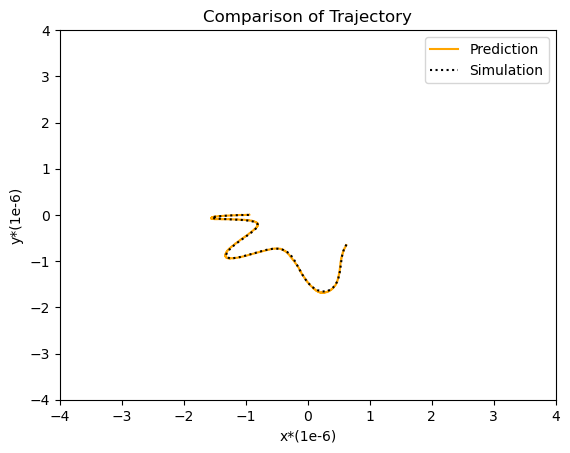

In [7]:
# 训练集预测效果
c = 612               # 5112, 612, 615, 617, 608, 599, 594, 588
valid_input = train_input[c:c+1]
valid_predict = new_m(valid_input).view(-1).cpu().detach().numpy().reshape(1, 2000)               
valid_label = train_label[c].cpu().detach().numpy().reshape(1, 2000)                                    
valid_predict = valid_predict.reshape(2000,)
valid_label = valid_label.reshape(2000,)
#print(valid_input)

plt.title('Comparison of Trajectory')
plt.plot(valid_predict[0:1000], valid_predict[1000:2000], color="orange", label='Prediction', linestyle='-')
plt.plot(valid_label[0:1000], valid_label[1000:2000], color="black", label='Simulation', linestyle=':')
plt.legend(loc='upper right')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x*(1e-6)')
plt.ylabel('y*(1e-6)')
plt.show()

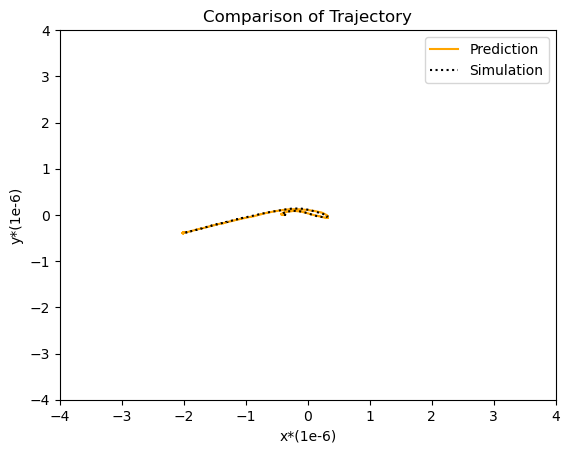

In [8]:
# 测试集预测效果
c = 698              # 1089, 654, 680
valid_input = test_input[c:c+1]
valid_predict = new_m(valid_input).view(-1).cpu().detach().numpy().reshape(1, 2000)               
valid_label = test_label[c].cpu().detach().numpy().reshape(1, 2000)                                    
valid_predict = valid_predict.reshape(2000,)
valid_label = valid_label.reshape(2000,)
#print(valid_input)

plt.title('Comparison of Trajectory')
plt.plot(valid_predict[0:1000], valid_predict[1000:2000], color="orange", label='Prediction', linestyle='-')
plt.plot(valid_label[0:1000], valid_label[1000:2000], color="black", label='Simulation', linestyle=':')
plt.legend(loc='upper right')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x*(1e-6)')
plt.ylabel('y*(1e-6)')
plt.show()